In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import trange

import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms
from torchvision.datasets import MNIST
from torch.utils.data import Dataset, DataLoader

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [2]:
def get_dataloader(train_batch_size, val_batch_size):
    train_dataset = datasets.MNIST('./MNIST_Dataset', train = True, download = True, transform = transforms.ToTensor())
    validation_dataset = datasets.MNIST("./MNIST_Dataset", train = False, download = True, transform = transforms.ToTensor())
    
    train_loader = DataLoader(dataset = train_dataset, batch_size = train_batch_size, shuffle = True)
    validation_loader = DataLoader(dataset = validation_dataset, batch_size = val_batch_size, shuffle = True)
    return train_loader, validation_loader

In [17]:
class MNIST_Autoencoder(nn.Module):
    def __init__(self, mode = 'training'):
        super(MNIST_Autoencoder, self).__init__()
        self.mode = mode
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True)
            )
        self.decoder = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 28*28),
            nn.Sigmoid()
            )
        self.encoder_outputs = []
        
    def forward(self, x):
        encoder_out = self.encoder(x)
        decoder_out = self.decoder(encoder_out)
        if self.mode == 'test':
            self.encoder_outputs.append(encoder_out)
        return decoder_out

In [4]:
epochs = 10
train_batch_size, val_batch_size = 10, 2000
lr = 0.001

loss_list = []

train_loader, validation_loader = get_dataloader(train_batch_size, val_batch_size)

model = MNIST_Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = lr)

for epoch in trange(epochs):
    print(epoch)
    for step, (img, label) in enumerate(train_loader):
        img, label = img.view(-1,28*28).to(device), label.to(device) # view는 reshape. -1 : 알아서 맞춰줌.
        # 원래 -1 자리는 배치사이즈 자리.
        
        m_img = model(img)
        
        optimizer.zero_grad()
        loss = criterion(m_img, img)
        loss.backward()
        optimizer.step()

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

0


 10%|████████▏                                                                         | 1/10 [03:06<28:00, 186.68s/it]

1


 20%|████████████████▍                                                                 | 2/10 [06:31<25:38, 192.26s/it]

2


 30%|████████████████████████▌                                                         | 3/10 [10:01<23:01, 197.37s/it]

3


 40%|████████████████████████████████▊                                                 | 4/10 [13:22<19:51, 198.65s/it]

4


 50%|█████████████████████████████████████████                                         | 5/10 [16:45<16:39, 199.84s/it]

5


 60%|█████████████████████████████████████████████████▏                                | 6/10 [20:33<13:52, 208.14s/it]

6


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [24:57<11:14, 224.91s/it]

7


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [29:39<08:04, 242.04s/it]

8


 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [34:43<04:20, 260.65s/it]

9


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [39:41<00:00, 238.14s/it]


In [5]:
#%%
print(model.state_dict().keys())
trained_dict = model.state_dict()

from collections import OrderedDict

enc_state_dict = OrderedDict()
dec_state_dict = OrderedDict()

for k, v in trained_dict.items():
    if k.startswith('encoder'):
        enc_state_dict[k] = v

for k, v in trained_dict.items():
    if k.startswith('decoder'):
        dec_state_dict[k] = v


odict_keys(['encoder.0.weight', 'encoder.0.bias', 'encoder.2.weight', 'encoder.2.bias', 'decoder.0.weight', 'decoder.0.bias', 'decoder.2.weight', 'decoder.2.bias'])


In [6]:
class MNIST_encoder(nn.Module):
    def __init__(self):
        super(MNIST_encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU()
            )
    
    def forward(self, x):
        return self.encoder(x)

In [7]:
class MNIST_generator(nn.Module):
    def __init__(self):
        super(MNIST_generator, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 28*28),
            nn.Sigmoid()
            )
    
    def forward(self, x):
        return self.decoder(x)
    

torch.Size([2000, 256])


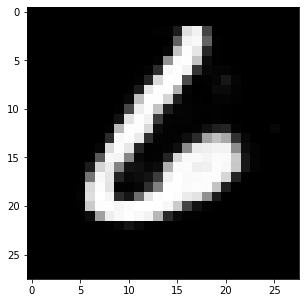

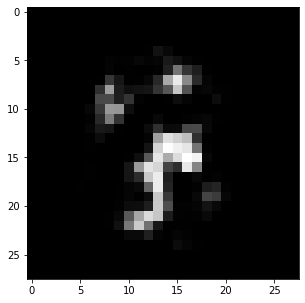

In [21]:
encoder = MNIST_encoder()
encoder.load_state_dict(enc_state_dict)

generator = MNIST_generator()
generator.load_state_dict(dec_state_dict)        
        
for step, (img, label) in enumerate(validation_loader):
    img = img.view(-1, 28*28)
    
    encoded_arr = encoder(img)
    m_img = generator(encoded_arr)
    
    
    t_img = m_img[0].view(28,28).detach().cpu().numpy()
    fig, ax = plt.subplots(figsize = (5,5))
    ax.imshow(t_img, 'gray')
    print(encoded_arr.shape)
    
    break        
#%%
random_num = torch.tensor(np.random.uniform(0, 2, size = (1,256)), dtype = torch.float)
m_img = generator(random_num)
    
t_img = m_img[0].view(28,28).detach().cpu().numpy()
fig, ax = plt.subplots(figsize = (5,5))
ax.imshow(t_img, 'gray')